# Sentiment Analysis for Mental Health: Detecting Depression and Anxiety Using NLP

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing

In [3]:
# Load dataset 
df = pd.read_csv("Combined Data.csv")

# Define a function for text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = word_tokenize(text)  # Tokenize words
    words = [w for w in words if w not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]  # Lemmatization
    return ' '.join(words)

# Handle missing values in 'statement' column
df['statement'] = df['statement'].fillna('')


# Apply preprocessing
df['clean_text'] = df['statement'].apply(preprocess_text)

status_mapping = {
    'Normal': 0,
    'Depression': 1,
    'Anxiety': 2,
    'Suicidal': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}

# Apply mapping to convert categorical labels into numeric values
df['status'] = df['status'].map(status_mapping)

# Verify if any unmapped values exist
if df['status'].isnull().sum() > 0:
    print("Warning: Some values in 'status' were not mapped correctly")

print("Data preprocessing completed!")


Data preprocessing completed!


In [4]:
# Drop NaN values
df = df.dropna(subset=['statement', 'status'])

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['status'], test_size=0.2, random_state=42)

## Feature Extraction (TF-IDF and Word2Vec)

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF transformation completed!")


TF-IDF transformation completed!


In [7]:
from gensim.models import Word2Vec

# Tokenize the text for Word2Vec
tokenized_train = [text.split() for text in X_train]
tokenized_test = [text.split() for text in X_test]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv

# Function to convert text into vector representation
def vectorize_text(text, model, vector_size=100):
    words = text.split()
    vector = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model:
            vector += model[word]
            count += 1
    return vector / count if count > 0 else vector

X_train_w2v = np.array([vectorize_text(text, word_vectors) for text in X_train])
X_test_w2v = np.array([vectorize_text(text, word_vectors) for text in X_test])

print("Word2Vec transformation completed!")


Word2Vec transformation completed!


## Model Training (Logistic Regression, Naïve Bayes, SVM, and LSTM)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Train Logistic Regression on TF-IDF
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# Train Naïve Bayes on TF-IDF
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

# Train SVM on TF-IDF
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

# Evaluate models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression F1-score:", f1_score(y_test, y_pred_lr, average='macro'))

print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naïve Bayes F1-score:", f1_score(y_test, y_pred_nb, average='macro'))

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM F1-score:", f1_score(y_test, y_pred_svm, average='macro'))


/home/jovyan/.rsm-msba/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.7457818833066264
Logistic Regression F1-score: 0.6782906838099291
Naïve Bayes Accuracy: 0.6443585634838345
Naïve Bayes F1-score: 0.5102317367279714
SVM Accuracy: 0.7498350457159015
SVM F1-score: 0.6837396484546716


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenizing the text for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Build LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM Model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Evaluate LSTM Model
y_pred_lstm = model.predict(X_test_pad).argmax(axis=1)
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("LSTM F1-score:", f1_score(y_test, y_pred_lstm, average='macro'))


In [ ]:
model.save("lstm_model.keras")

In [11]:
from tensorflow.keras.models import load_model
model_lstm = load_model("lstm_model.keras")
# Evaluate LSTM Model
y_pred_lstm = model_lstm.predict(X_test_pad).argmax(axis=1)
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("LSTM F1-score:", f1_score(y_test, y_pred_lstm, average='macro'))

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
LSTM Accuracy: 0.7428598359883118
LSTM F1-score: 0.6882969753454703


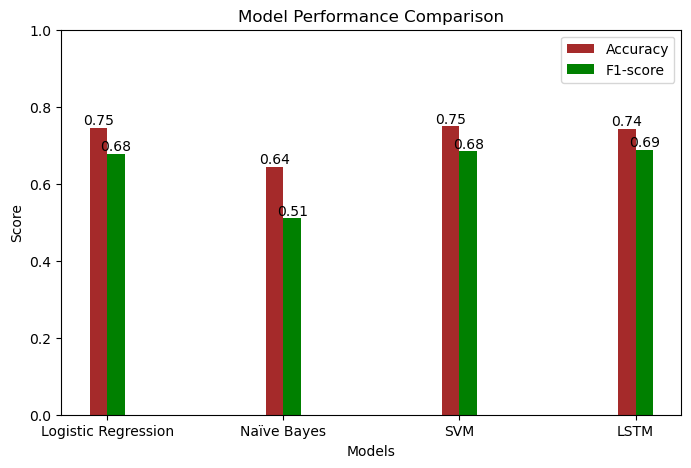

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Logistic Regression', 'Naïve Bayes', 'SVM', 'LSTM']

# Accuracy and F1-score results from your models
accuracy_scores = [
    accuracy_score(y_test, y_pred_lr),  # Logistic Regression
    accuracy_score(y_test, y_pred_nb),  # Naïve Bayes
    accuracy_score(y_test, y_pred_svm),  # SVM
    accuracy_score(y_test, y_pred_lstm)  # LSTM
]

f1_scores = [
    f1_score(y_test, y_pred_lr, average='macro'),
    f1_score(y_test, y_pred_nb, average='macro'),
    f1_score(y_test, y_pred_svm, average='macro'),
    f1_score(y_test, y_pred_lstm, average='macro')
]

# Plotting the results
x = np.arange(len(models))
width = 0.1  # Bar width

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='brown')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-score', color='green')

# Labels and title
ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show values on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

plt.ylim(0, 1)  # Keep scale between 0-1
plt.show()
